# Eye Disease Classification based on Retinal Images

Addison 2024-02-15

## Introduction

This project aims to build a model to identify types of eye diseases based on retinal images. To this end, this project will use a dataset that contains 4217 retinal images representing 4 types of eye conditions: **Normal, Cataract, Diabetic Retinopathy, and Glaucoma.**

 The dataset could be obtained through this link:

https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification/data

## Exploring the data

First, let's import the necessary libraries and read all the files. After that, we'll integrate all the datasets into one variable named **data**.

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

Next, we choose the:
- **batch size:** the number of training examples utilized in one iteration
- **image size** for input images. In this project, we'll resize images to 256x256 pixels
- **type of color channels**. In this project, we'll choose **RGB (Red, Green, Blue)**, so the number of color channels = 3
- **number of epochs:** the number of times the entire training dataset is passed forward and backward through the neural network

In [2]:
batch_size = 32
image_size = 256
num_channel = 3
num_epoch = 50

Then, we'll read all the files in a folder named **dataset** and integrate them into one variable named **data**. During the image loading process, we'll shuffle the dataset for randomness.

In [3]:
data = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    seed = 222,
    shuffle = True,
    image_size = (image_size, image_size),
    batch_size = batch_size)

Found 4217 files belonging to 4 classes.


Next, we'll check the **class names** in our dataset to ensure that it contains images representing aforementioned 4 types of eye conditions.

In [4]:
class_name = data.class_names
class_name

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

Now, we're going to **display some retinal images** in our first image batch.

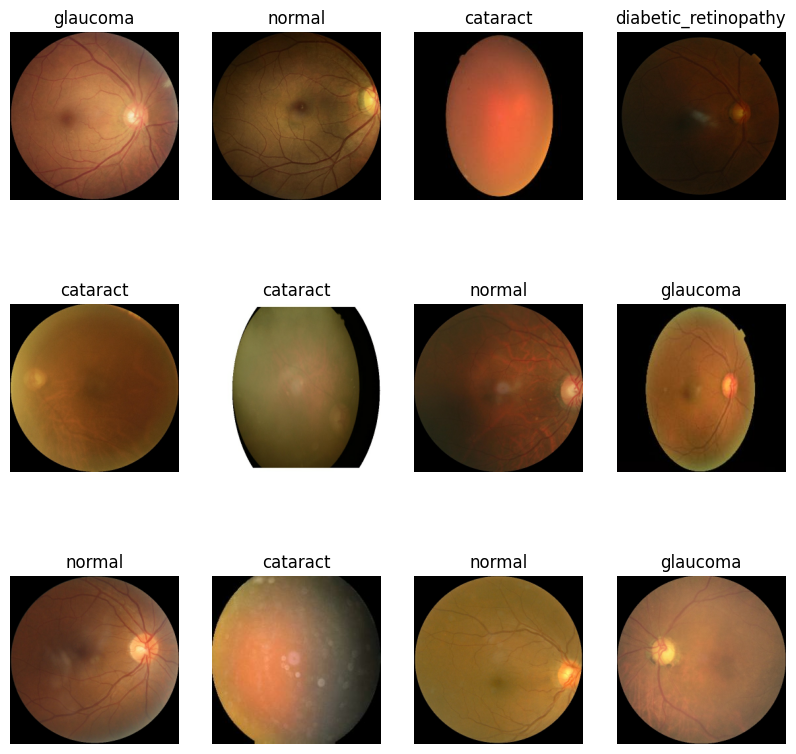

In [5]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in data.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[label_batch[i]])
        plt.axis("off")

## Splitting the dataset

In this project, we'll use **80% of the dataset for training, 10% for validation, and the other 10% for testing.**

In [6]:
# Check the length of the dataset
data_len = len(data)
data_len

132

In [7]:
# Calculate the length of the training set
train_len = round(len(data)*0.8)
train_len

106

In [8]:
# Calculate the length of the validating and testing sets:
val_test_len = int((data_len - train_len)/2)
val_test_len

13

Now, we're going to **shuffle and then split the dataset** into three sets based on the calculation above.

In [9]:
# Shuffle the data
data = data.shuffle(10000, seed = 222)

# Split the dataset
train = data.take(train_len)
val = data.skip(train_len).take(val_test_len)
test = data.skip(train_len).skip(val_test_len)

Next, we'll **cache, shuffle, and prefetch the training, validation, and testing tests** for data loading and model execution optimization.

In [10]:
train = train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val = val.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test = test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the model


### Data Augmentation

Now we're going to create data augmentation layers to prevent overfitting and improve the model's ability to generalize well to new, unseen images. These layers will be applied to the training set to randomly flip the input images horizontally and/or vertically and rotate them by 0.3 radians.

In [11]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.3),
])

train = train.map(
    lambda image, label: (data_augmentation(image, training=True), label)
).prefetch(buffer_size=tf.data.AUTOTUNE)

### Define the model

Next, we'll structure a convolutional neural network (CNN) model:
- First, we'll **resize images** to 256x256 dimension then **rescale** the pixel values to be in the range [0, 1].
- Second, we'll **use several pairs of Conv2D (32/64 filters, filter size = (3,3), activation function = "ReLU") and MaxPooling2D layers (kernel size = (2,2))**. Conv2D layers are to learn patterns of input images while MaxPooling2D layers are to downsample the input feature map.
- Third,  we'll use a **Flatten layer** to **flatten the output** from the convolutional layers into a 1D vector that can be fed into the dense layers for further processing and classification.
- Fourth, we'll use a **Dense layer with 64 neurons and "ReLU" activation function** to extract and learn complex patterns and features from the input images.
- Finally, we'll use a **Dense layer with 4 neurons, which is the number of eye conditions, and "Softmax" activation function** to convert the raw output scores of each class into probabilities.

In [12]:
input_shape = (batch_size, image_size, image_size, num_channel)

model = models.Sequential([
    layers.experimental.preprocessing.Resizing(image_size, image_size),
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(32, kernel_size = (3,3), activation = 'relu',
                  input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(4, activation = 'softmax')
])

Next, we'll **construct the model's layers and initialize their weights** according to the specified input_shape.

In [13]:
model.build(input_shape = input_shape)

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (32, 256, 256, 3)         0         
                                                                 
 rescaling (Rescaling)       (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

From the summary, it's clear that there are 183 812 trainable parameters in the model that will be updated during training.

Next, we'll **configure the model for training:**
- **Optimizer:** 'adam' -  Adaptive Moment Estimation. It will adjust the learning rate during training.
- **Loss function:** Sparse Categorical Cross Entropy. This loss function is suitable for multi-class classification problems where the target labels are integers.
- **Metrics:** 'accuracy' will measure the proportion of correctly classified examples.

In [15]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy'])

Now, we're going to **train the model on the training set and validate it on the validation set**.

In [16]:
history = model.fit(
    train,
    batch_size = batch_size,
    validation_data = val,
    verbose = 1,
    epochs = num_epoch)

Epoch 1/50
106/106 [==============================] - 82s 547ms/step - loss: 1.2843 - accuracy: 0.3784 - val_loss: 1.2169 - val_accuracy: 0.4808
Epoch 2/50
106/106 [==============================] - 37s 347ms/step - loss: 1.0084 - accuracy: 0.5610 - val_loss: 0.9402 - val_accuracy: 0.6058
Epoch 3/50
106/106 [==============================] - 36s 343ms/step - loss: 0.8481 - accuracy: 0.6437 - val_loss: 0.7990 - val_accuracy: 0.6418
Epoch 4/50
106/106 [==============================] - 39s 371ms/step - loss: 0.7702 - accuracy: 0.6736 - val_loss: 0.7601 - val_accuracy: 0.6370
Epoch 5/50
106/106 [==============================] - 38s 361ms/step - loss: 0.6916 - accuracy: 0.7028 - val_loss: 0.6556 - val_accuracy: 0.7163
Epoch 6/50
106/106 [==============================] - 38s 358ms/step - loss: 0.6418 - accuracy: 0.7329 - val_loss: 0.6541 - val_accuracy: 0.7260
Epoch 7/50
106/106 [==============================] - 38s 361ms/step - loss: 0.6109 - accuracy: 0.7504 - val_loss: 0.6616 - val_ac

Now, we're going to **evaluate the trained model on a test set.**

In [17]:
score = model.evaluate(test)
score

13/13 [==============================] - 12s 32ms/step - loss: 0.2573 - accuracy: 0.8966


[0.25729432702064514, 0.8966346383094788]

The accuracy score of the prediction model is relatively high, suggesting that the model produces reliable results.

### Training & Validation Loss and Accuracy Visualization

In this section, we'll plot Training & Validation Loss and Accuracy to evaluate the model performance.

In [18]:
# Extracting loss and accuracy metrics from the training history

loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

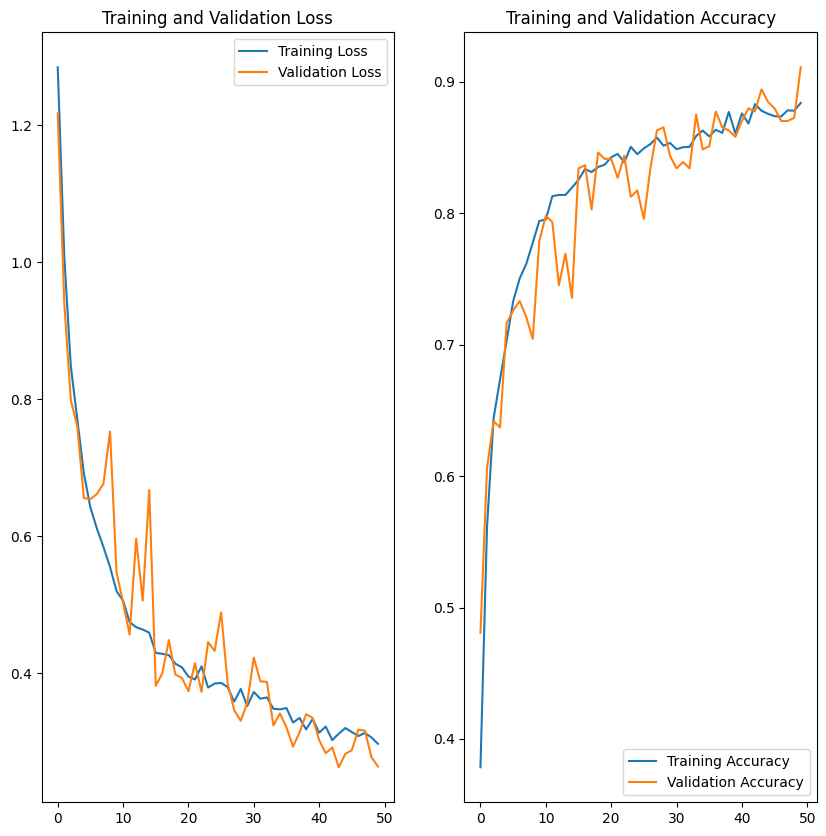

In [19]:
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.plot(range(num_epoch), loss, label = 'Training Loss')
plt.plot(range(num_epoch), val_loss, label = 'Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')


plt.subplot(1, 2, 2)
plt.plot(range(num_epoch), accuracy, label = 'Training Accuracy')
plt.plot(range(num_epoch), val_accuracy, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()

Based on the graphs, it's evident that:
- The **training loss decreases steadily over epochs**, indicating that the model is learning the underlying patterns in the data.
- The **validation loss also decreases along with the training loss**, indicating that the model is generalizing well to unseen data.
- The **training accuracy increases steadily** as the model learns from the training data.
- Similarly, the **validation accuracy increases along with the training accuracy**, indicating that the model is performing well on unseen data.

Thus, it can be concluded that our model has achieved a **good fit**.

## Create a function for single prediction

Now, we're going to create a function named **single_prediction** that takes a model and an image as input, and returns the predicted class and confidence.

In [20]:
def single_prediction(model, image):
    # Convert the image to an array
    image_array = tf.keras.preprocessing.image.img_to_array(image.numpy())
    # Expand the dimensions to match the model input shape
    image_array = tf.expand_dims(image_array, 0)

    # Make prediction
    prediction = model.predict(image_array)

    # Get the predicted class and confidence
    predicted_class = class_name[np.argmax(prediction[0])]
    confidence = round(100 * (np.max(prediction[0])), 2)

    return predicted_class, confidence

In [21]:
def single_prediction(model, image):
    # Convert the image to an array
    image_array = tf.keras.preprocessing.image.img_to_array(image)
    # Expand the dimensions to match the model input shape
    image_array = tf.expand_dims(image_array, 0)

    # Make predictions
    predictions = model.predict(image_array)

    # Get the predicted class and confidence
    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)

    return predicted_class, confidence


Next, we'll use the **single_prediction** function to make predictions on some retinal images. We'll also display actual labels and images for comparison.

1/1 [==============================] - 0s 19ms/step


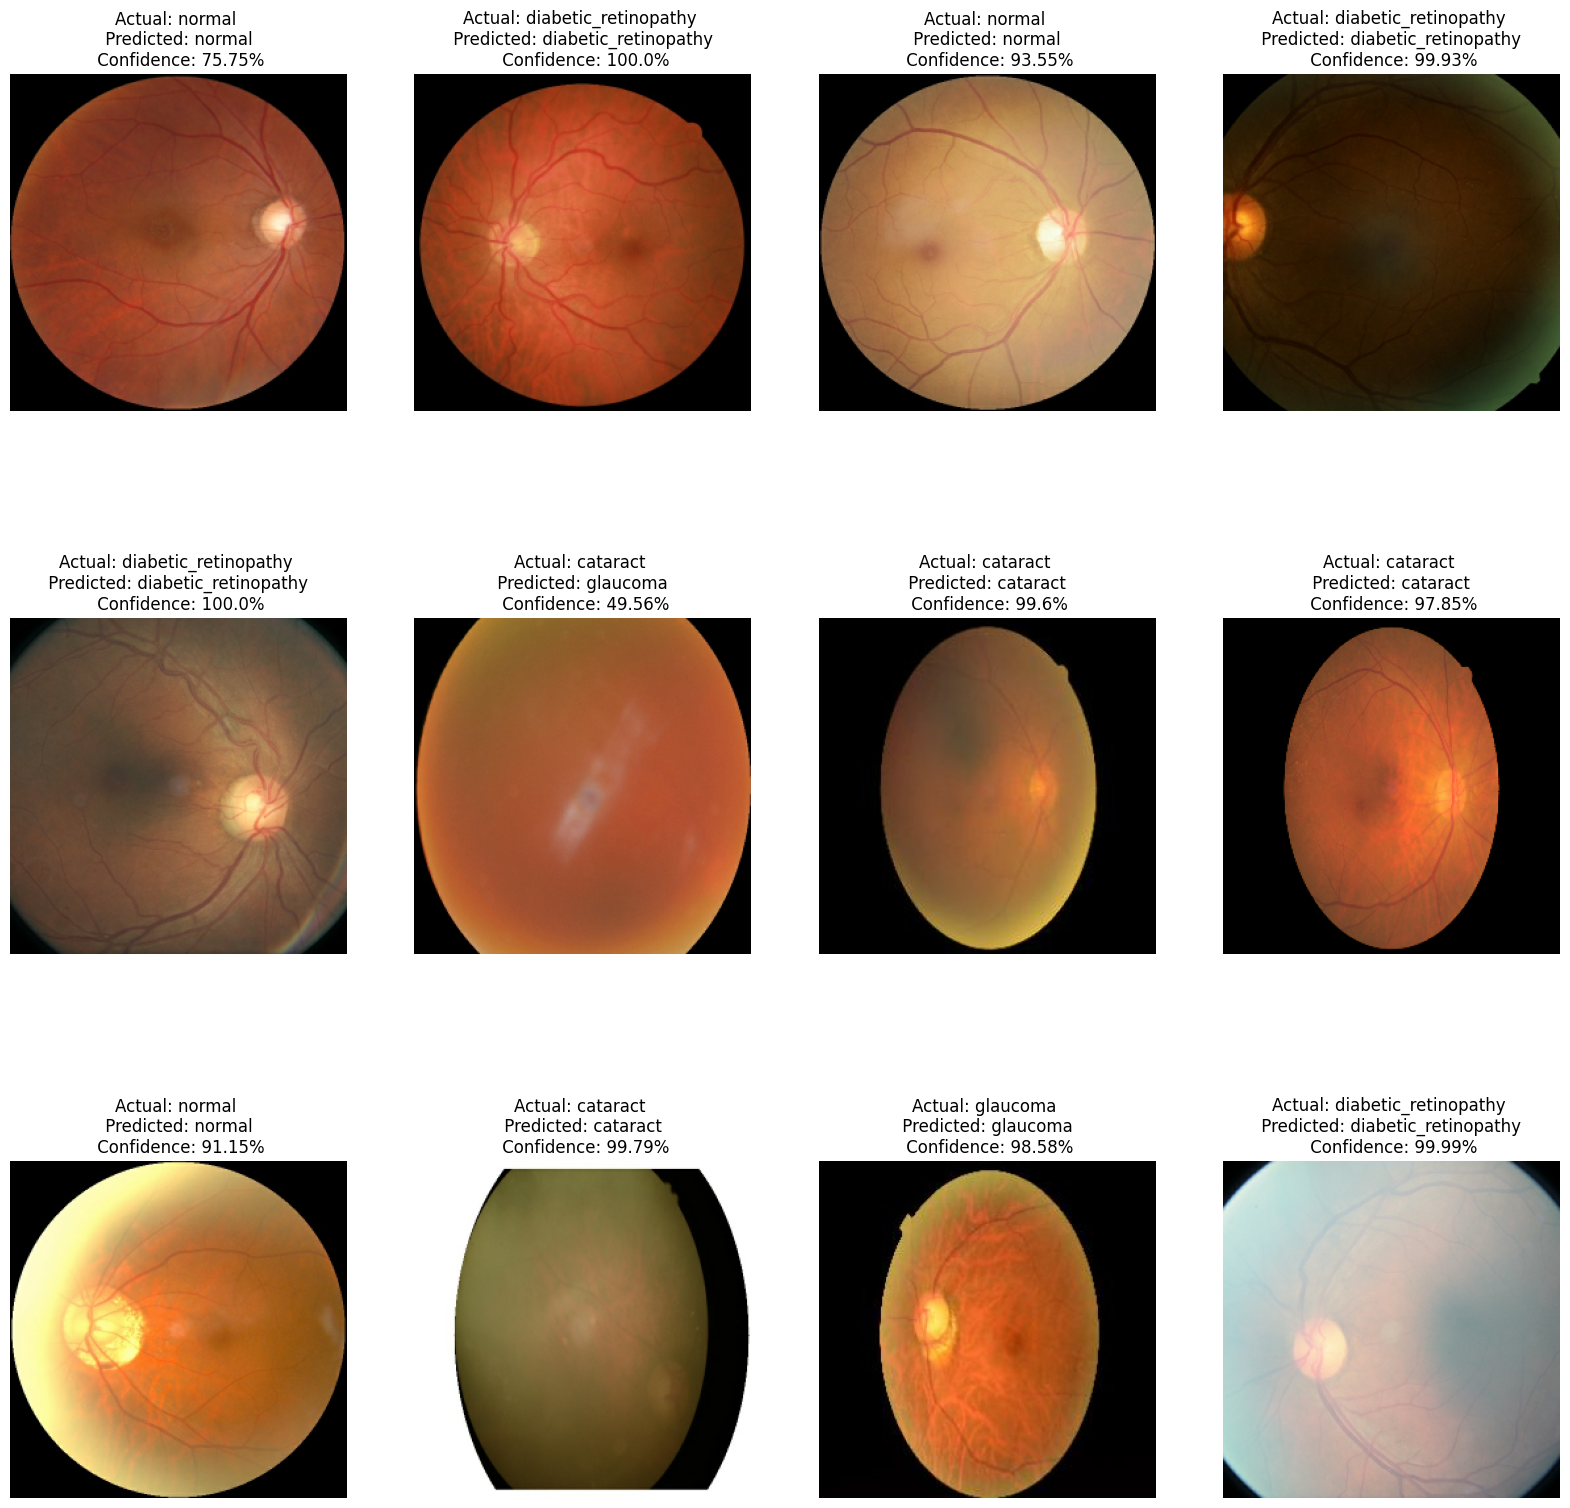

In [22]:
plt.figure(figsize = (20, 20))
# Take the first batch of images from the test dataset
for image, label in test.take(1):
    # Iterate over each image in the batch
    for i in range(12):
        # Plot each image
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image[i].numpy().astype("uint8"))

        # Use the single_prediction function to get the predicted class and confidence
        predicted_class, confidence = single_prediction(model, image[i].numpy())
        # Get the actual class from the labels
        actual_class = class_name[label[i]]

        # Set the title with the actual class, predicted class, and confidence
        plt.title(f"Actual: {actual_class} \n Predicted: {predicted_class} \n Confidence: {confidence}%")

        plt.axis("off")

It is noticeable that the model tends to produce correct predictions when confidence scores are high, and vice versa. This indicates a correlation between confidence scores and prediction accuracy.

## Conclusions and suggestions for future research
The accuracy score of the prediction model is pretty good, indicating that the prediction model produces considerably reliable results.

However, further research is recommended to enhance the performance of the model. This could involve increasing the number of input images, experimenting with different learning rates, batch sizes, image sizes, and model architectures. Additionally, utilizing pre-trained models could potentially improve the accuracy score.